<p float="middle">
    <img src="image/CQF_gain_skills.gif" />
</p>


<br>
<center> <h3> This demo and Q&A can be relevant to ML Assignment (Exam 3)</h3> </center>
<center> <h3>Dr Richard Diamond </h3> </center>
<br>



# Predicing Asset Price Direction / Sign of Return


<br>

* **Foreword.** Remember that in addition to large-cap equities (eg, AMZN, GOOG) there are interesting industries (eg, Healthcare, Biotech) and other asset classes. You are more likely to find a sensible prediction scheme for commodity futures rather than a popular large cap.
<br><br>


* The way to organise the work: select your features (say 7-10 columns) and run Classifier.fit() on them. This is no different than running a regression.

<br>
Then you have results from different “regressions”. For each produce Area under ROC, Confusion Matrix, Transition Probabilities scatterplot (separate for each predicted Class label).

<br>

* One approach (but not limiting): run a classifier on all features given (cover different kinds of features) – your reasonable choices of time window for SMA, EMA, Momentum.  After that, throw out features not contributing and run on the reduced set.

[EMA example](https://user42.tuxfamily.org/chart/manual/Exponential-Moving-Average.html), smoothing factor $\alpha = 2/(N_{obs}+1)$.

<br>

* You may have situations of 'no move', especially if analysing a large market index -- the daily average return can be $O(0.04\%)$. Because of the number of 'no moves', trinomial classification $[-1, 0, 1 ]$ is more appropriate but we remain working on the binomial scheme.  To keep the continuity of time series, we can re-label 'no moves' as positive moves.  The exclusion of 'no move' observations removes our ability to predict for each next trading day -- therefore, P\&L backtesting will be affected.

<br><br>

* OLS given for the illustration only.  Regressing on past returns (=lagged values) is the common model-free setup known as _Vector Autoregression_ (VAR). VAR does not work to predict daily return -- the order of error will be 150-200%. 

<br>

Second, OLS is **not** a valid regression model for binary dependent variable {0, 1}. To have non-linear link between dependent variable (such as binary 0,1  or Probability 0.01..0.99) the `Genearalized Linear Models' approach was theoretically developed and Logistic Regression.


-----

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

### Getting Historical Data

In [25]:
# LOAD FROM EXCEL
# We have downloaded data previously in FP_EquitiesData notebook

data = pd.read_excel('data/EquitiesDataGOOG.xlsx', sheet_name="Sheet1", index_col=0, usecols=[0,5])
data.columns = ['price']  # Adj Close Price

In [21]:
data.head()

price
Date              
2010-09-30  261.91
2010-10-01  261.83
2010-10-04  260.20
2010-10-05  268.11
2010-10-06  266.18

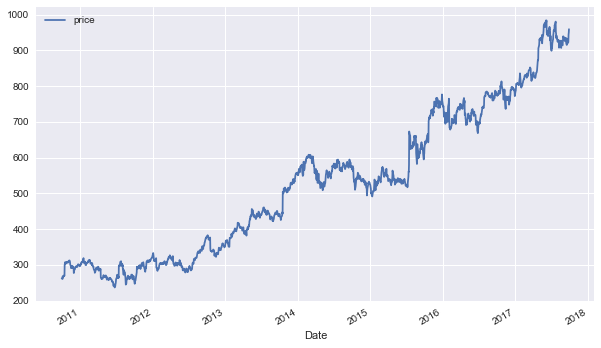

In [7]:
data.plot(figsize=(10, 6));

In [26]:
# SEPARATE for Features Correlation
data_advf = data.copy() #save a copy for advanced look at lagged returns over long term

data_advf['Returns'] = np.log(data_advf).diff()

data_advf.head()

price   Returns
Date                        
2010-09-30  261.91       NaN
2010-10-01  261.83 -0.000305
2010-10-04  260.20 -0.006245
2010-10-05  268.11  0.029947
2010-10-06  266.18 -0.007225

In [19]:
data['return'] = np.log(data / data.shift(1))

In [9]:
data.head()

price    return
Date                        
2010-09-30  261.91       NaN
2010-10-01  261.83 -0.000305
2010-10-04  260.20 -0.006245
2010-10-05  268.11  0.029947
2010-10-06  266.18 -0.007225

In [10]:
lags = 5

cols = []
for lag in range(1, lags+1):
    col = 'ret_%d' % lag
    data[col] = data['return'].shift(lag)
    cols.append(col)
    
# Column indexation is from 0, so we effectively have range(1, 6) for returns
# CHECK NOT TO USE Return IN ACTUAL PREDICTION

In [11]:
data.head(10)

price    return     ret_1     ret_2     ret_3     ret_4     ret_5
Date                                                                          
2010-09-30  261.91       NaN       NaN       NaN       NaN       NaN       NaN
2010-10-01  261.83 -0.000305       NaN       NaN       NaN       NaN       NaN
2010-10-04  260.20 -0.006245 -0.000305       NaN       NaN       NaN       NaN
2010-10-05  268.11  0.029947 -0.006245 -0.000305       NaN       NaN       NaN
2010-10-06  266.18 -0.007225  0.029947 -0.006245 -0.000305       NaN       NaN
2010-10-07  264.02 -0.008148 -0.007225  0.029947 -0.006245 -0.000305       NaN
2010-10-08  267.17  0.011860 -0.008148 -0.007225  0.029947 -0.006245 -0.000305
2010-10-11  268.41  0.004631  0.011860 -0.008148 -0.007225  0.029947 -0.006245
2010-10-12  269.68  0.004720  0.004631  0.011860 -0.008148 -0.007225  0.029947
2010-10-13  270.64  0.003553  0.004720  0.004631  0.011860 -0.008148 -0.007225

In [12]:
data.dropna(inplace=True)

data = data.drop(columns="price")

data['return_sign'] = np.sign(data['return'].values)

data_adv = data.copy() #save a copy for advanced methods (classifiers), as compared to the linear regression

In [13]:
data.head()

return     ret_1     ret_2     ret_3     ret_4     ret_5  \
Date                                                                     
2010-10-08  0.011860 -0.008148 -0.007225  0.029947 -0.006245 -0.000305   
2010-10-11  0.004631  0.011860 -0.008148 -0.007225  0.029947 -0.006245   
2010-10-12  0.004720  0.004631  0.011860 -0.008148 -0.007225  0.029947   
2010-10-13  0.003553  0.004720  0.004631  0.011860 -0.008148 -0.007225   
2010-10-14 -0.004370  0.003553  0.004720  0.004631  0.011860 -0.008148   

            return_sign  
Date                     
2010-10-08          1.0  
2010-10-11          1.0  
2010-10-12          1.0  
2010-10-13          1.0  
2010-10-14         -1.0

### ASIDE. Lagged Returns Long-Term

In [27]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    data_advf['Ret_'+str(r)] = data_advf.Returns.rolling(r).sum()
    data_advf['Std_'+str(r)] = data_advf.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

# Drop NaN values
data_advf.dropna(inplace=True)

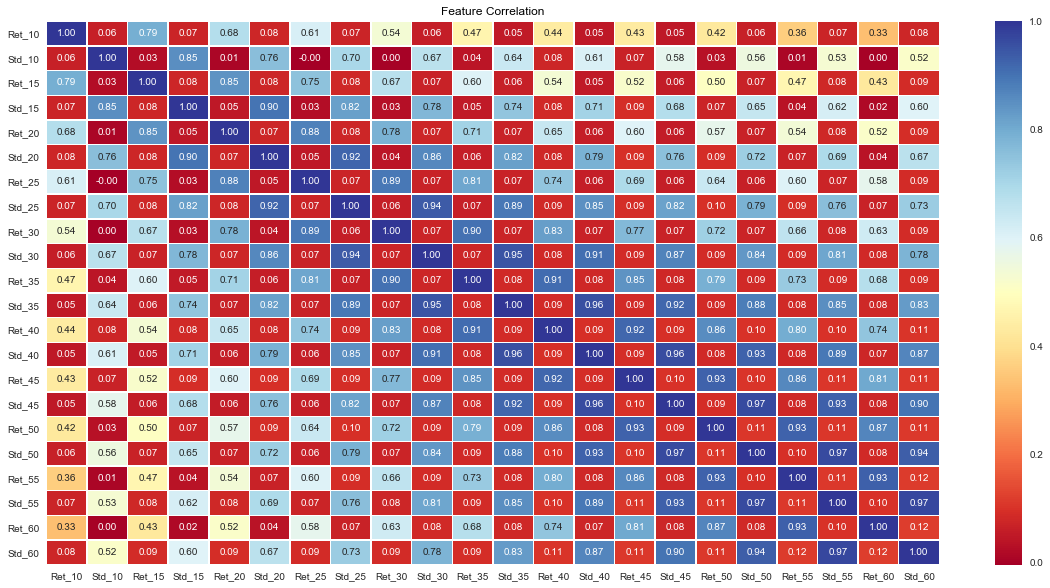

In [28]:
# Derive features correlation
import seaborn as sns
corrmat = data_advf.drop(['price', 'Returns'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap='RdYlBu')
ax.set_title('Feature Correlation', fontsize=12, color='black');

--------

### MLE Methodology for OLS Regression

Below work is illustration-only. Do not run OLS in your assignments and projects.


When the assumption of Normality of residuals holds: $\epsilon_t$ is _iid_ $N(0,\sigma^2)$, **the linear regression** $y_t = \boldsymbol{\hat{\beta} x_t} + \epsilon_t$ has MLE properties. 

That means estimated coefficients $\boldsymbol{\hat{\beta}}$ are 

* consistent (i.e., close to unknown true estimates $\beta$ with low tolerance) and
* asymptotically efficient (i.e., their variance is known and minimised). 

Estimates $\boldsymbol{\hat\beta}$ in fact, maximise the following **joint Normal** likelihood:

$$ \mathbf{L} = \left(\frac{1}{\sqrt{2 \pi \sigma^2}}\right)^T \exp{-\frac{1}{2} \left[ \frac{\epsilon_{1}^2}{\sigma^2} + \frac{\epsilon_{2}^2}{\sigma^2} + \cdots + \frac{\epsilon_{T}^2}{\sigma^2} \right]} $$

Substituting $\epsilon_t = y_t - \boldsymbol{\hat{\beta} x_t}$ and taking log gives for an individual observation -- I call this quantity a contribution of likelihood from an observation (data row values of features) at time _t_
$$ \log{L_t}  = - \frac{1}{2} \log{2\pi \sigma^2}  - \frac{1}{2} \frac{(y_t - \boldsymbol{\hat{\beta} x_t})^2}{\sigma^2} $$

Total log-likelihood for a regression model is the sum of contributions from each observation $\log \mathbf{L} = \sum_{t=1}^{T} L_t$. 

Numerical MLE varies $\boldsymbol{\hat{\beta}}$ to maximise $\log \mathbf{L}$. This can be done by any non-specific optimisation routine, such as Excel Solver. It is clear to spot that log-likelihood is maximised by **minimising** the residual sum of squares  

$$RSS = \sum_{t=1}^{T} \epsilon_t^2 =  \sum_{t=1}^{T} (y_t - \boldsymbol{\hat{\beta} x_t})^2$$.


[Residual sum of squares (RSS)](https://en.wikipedia.org/wiki/Residual_sum_of_squares) is also known as the sum of squared residuals (SSR) or the sum of squared estimate of errors (SSE).

-------

**CAUTION** OLS is an **invalid** model for binary dependent variable {0, 1}. Think about a change in MLE function for such variable.


In [13]:
# Regression from NUMPY library
reg_coef = np.linalg.lstsq(data[cols].values, data['return_sign'])[0]

# PREFER delegates to use STATSMOTELS
#import statsmodels.api as sm

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [14]:
reg_coef

array([ 1.13255353,  0.34409898, -2.87238464, -0.40975749, -1.38671844])

In [15]:
data['ols_pred'] = np.sign(np.dot(data[cols].values, reg_coef)) #dot product

In [16]:
data.head(15)

return     ret_1     ret_2     ret_3     ret_4     ret_5  \
Date                                                                     
2010-10-08  0.011860 -0.008148 -0.007225  0.029947 -0.006245 -0.000305   
2010-10-11  0.004631  0.011860 -0.008148 -0.007225  0.029947 -0.006245   
2010-10-12  0.004720  0.004631  0.011860 -0.008148 -0.007225  0.029947   
2010-10-13  0.003553  0.004720  0.004631  0.011860 -0.008148 -0.007225   
2010-10-14 -0.004370  0.003553  0.004720  0.004631  0.011860 -0.008148   
2010-10-15  0.106028 -0.004370  0.003553  0.004720  0.004631  0.011860   
2010-10-18  0.026677  0.106028 -0.004370  0.003553  0.004720  0.004631   
2010-10-19 -0.016119  0.026677  0.106028 -0.004370  0.003553  0.004720   
2010-10-20  0.000231 -0.016119  0.026677  0.106028 -0.004370  0.003553   
2010-10-21  0.006582  0.000231 -0.016119  0.026677  0.106028 -0.004370   
2010-10-22  0.000885  0.006582  0.000231 -0.016119  0.026677  0.106028   
2010-10-25  0.006468  0.000885  0.006582  0.000231 -0.016119  0.026677   
2010-10-26  0.003381  0.006468  0.000885  0.006582  0.000231 -0.016119   
2010-10-27 -0.003446  0.003381  0.006468  0.000885  0.006582  0.000231   
2010-10-28  0.003446 -0.003446  0.003381  0.006468  0.000885  0.006582   

            return_sign  ols_pred  
Date                               
2010-10-08          1.0      -1.0  
2010-10-11          1.0       1.0  
2010-10-12          1.0      -1.0  
2010-10-13          1.0      -1.0  
2010-10-14         -1.0      -1.0  
2010-10-15          1.0      -1.0  
2010-10-18          1.0       1.0  
2010-10-19         -1.0       1.0  
2010-10-20          1.0      -1.0  
2010-10-21          1.0      -1.0  
2010-10-22          1.0      -1.0  
2010-10-25          1.0      -1.0  
2010-10-26          1.0       1.0  
2010-10-27         -1.0       1.0  
2010-10-28          1.0      -1.0

#### Count number of predicted moves UP and DOWN

In [17]:
data['ols_pred'].value_counts()

#c.value_counts()[1] / (c.value_counts().sum()) #We were UP this percentage of observations/days

-1.0    938
 1.0    819
Name: ols_pred, dtype: int64

**False Negatives -- Type II Error**

The probelm transpires: the model is likely to be bad at predicting negative returns, there are a lot of **false negatives** with -1.0 label. 

In terms of generated asset path: in case of bad prediction of negative returns (moves down) we can observe the path drifting downwards and downwards. But that is for later.

---

#### Backtesting in context of rebalancing

| 'ols_pred' |  'return' | Result P\&L |
|---|---|--- |
|NEGATIVE 'ols_pred'| NEGATIVE 'return' | POSITIVE P\&L |
|NEGATIVE 'ols_pred'| POSITIVE 'return' (move up) | NEGATIVE P\&L, Loss |
|POSITIVE 'ols_pred'| NEGATIVE 'return' | NEGATIVE P\&L, Loss |
|POSITIVE 'ols_pred'| POSITIVE 'return' (move up) | POSITIVE P\&L |


Exercise care with Dr Hilpisch code, particularly on 'vectorised backtesting' where correctly predicted negative sign translates into the Positive P\&L -- that assumes daily rebalancing (betting) rather than replication of the actual asset path.


In [56]:
data['ols_pred_backtest'] = data['return'] * data['ols_pred']

**So above multiplication represents a sequence of daily bets**, based on the sign (up/down move) predicted from past returns.

<br>

The actual return that realises today $t$, is \% P\&L that one makes (loses) on the bet of \$100, for example if return today is POSITIVE 0.018 and predcited sign was POSITIVE, then P\&L is 1.18%.

------

<br>


$$ Return_{pred} = Z^* \times \sigma $$

Assume we want to have more model-like prediction. Then, we will use standard deviation, which gives some measure of randomness.

* We use std dev from the dataset but that can be estimated from any prevoius holdout period/window. Such backtesting requires past data but not regular daily update of return -- the latter is historical backtesting.

* $Z^* = \pm 0.7$ of the standard deviation translates into betting \%70 of one sigma -- the Actual P\&L which would still depend on actual return. But we can plot cumulative P\&L from 'ols_pred_move' to see if matches with the asset path. It also is possible to do P\&L Attribution test on such std dev model:

<br>

'ols_pred_move' is in effect, our **Theoretical P\&L**

<br>

'return' is the **Actual P\&L**

<br>

* Why z-score of $\pm 0.7$? This is because empirical asset returns are not well-Normal and between $\pm 2$ standard deviation, but their density/histogram is high-peak (high mode). If you standardise returns $ z_t = (r_t - \mu) / \sigma$ the histogram of $z_t$ will have bars within  $\pm 0.7$.


* Instead of $\pm 0.7$ and to provide negative outcomes, we can use simulated values of Random Normal $\phi$ which can be positive or negative.


In [58]:
stdev = data['return'].std()  #from a whole dataset but you can introduce Train/Test split

data['ols_pred_move'] = 0.7 * stdev * (data['ols_pred'])
data['ols_pred_move_FUDGED'] = 0.7 * stdev * ( - data['ols_pred']) #PREDICTION INVERTED!

data['ols_pred_ABSOLUTE'] = abs(data['return']) * data['ols_pred']

In [53]:
data.head(20)

return     ret_1     ret_2     ret_3     ret_4     ret_5  \
Date                                                                     
2010-10-08  0.011860 -0.008148 -0.007225  0.029947 -0.006245 -0.000305   
2010-10-11  0.004631  0.011860 -0.008148 -0.007225  0.029947 -0.006245   
2010-10-12  0.004720  0.004631  0.011860 -0.008148 -0.007225  0.029947   
2010-10-13  0.003553  0.004720  0.004631  0.011860 -0.008148 -0.007225   
2010-10-14 -0.004370  0.003553  0.004720  0.004631  0.011860 -0.008148   
2010-10-15  0.106028 -0.004370  0.003553  0.004720  0.004631  0.011860   
2010-10-18  0.026677  0.106028 -0.004370  0.003553  0.004720  0.004631   
2010-10-19 -0.016119  0.026677  0.106028 -0.004370  0.003553  0.004720   
2010-10-20  0.000231 -0.016119  0.026677  0.106028 -0.004370  0.003553   
2010-10-21  0.006582  0.000231 -0.016119  0.026677  0.106028 -0.004370   
2010-10-22  0.000885  0.006582  0.000231 -0.016119  0.026677  0.106028   
2010-10-25  0.006468  0.000885  0.006582  0.000231 -0.016119  0.026677   
2010-10-26  0.003381  0.006468  0.000885  0.006582  0.000231 -0.016119   
2010-10-27 -0.003446  0.003381  0.006468  0.000885  0.006582  0.000231   
2010-10-28  0.003446 -0.003446  0.003381  0.006468  0.000885  0.006582   
2010-10-29 -0.007950  0.003446 -0.003446  0.003381  0.006468  0.000885   
2010-11-01  0.002124 -0.007950  0.003446 -0.003446  0.003381  0.006468   
2010-11-02  0.000979  0.002124 -0.007950  0.003446 -0.003446  0.003381   
2010-11-03  0.007408  0.000979  0.002124 -0.007950  0.003446 -0.003446   
2010-11-04  0.006582  0.007408  0.000979  0.002124 -0.007950  0.003446   

            return_sign  ols_pred  ols_pred_move_INVERTED  ols_pred_return  \
Date                                                                         
2010-10-08          1.0      -1.0                0.010402        -0.011860   
2010-10-11          1.0       1.0               -0.010402         0.004631   
2010-10-12          1.0      -1.0                0.010402        -0.004720   
2010-10-13          1.0      -1.0                0.010402        -0.003553   
2010-10-14         -1.0      -1.0                0.010402         0.004370   
2010-10-15          1.0      -1.0                0.010402        -0.106028   
2010-10-18          1.0       1.0               -0.010402         0.026677   
2010-10-19         -1.0       1.0               -0.010402        -0.016119   
2010-10-20          1.0      -1.0                0.010402        -0.000231   
2010-10-21          1.0      -1.0                0.010402        -0.006582   
2010-10-22          1.0      -1.0                0.010402        -0.000885   
2010-10-25          1.0      -1.0                0.010402        -0.006468   
2010-10-26          1.0       1.0               -0.010402         0.003381   
2010-10-27         -1.0       1.0               -0.010402        -0.003446   
2010-10-28          1.0      -1.0                0.010402        -0.003446   
2010-10-29         -1.0      -1.0                0.010402         0.007950   
2010-11-01          1.0      -1.0                0.010402        -0.002124   
2010-11-02          1.0      -1.0                0.010402        -0.000979   
2010-11-03          1.0       1.0               -0.010402         0.007408   
2010-11-04          1.0       1.0               -0.010402         0.006582   

            ols_pred_move  ols_pred_return_abs  ols_pred_move_FUDGED  
Date                                                                  
2010-10-08      -0.010402            -0.011860              0.010402  
2010-10-11       0.010402             0.004631             -0.010402  
2010-10-12      -0.010402            -0.004720              0.010402  
2010-10-13      -0.010402            -0.003553              0.010402  
2010-10-14      -0.010402            -0.004370              0.010402  
2010-10-15      -0.010402            -0.106028              0.010402  
2010-10-18       0.010402             0.026677             -0.010402  
2010-10-19       0.010402    

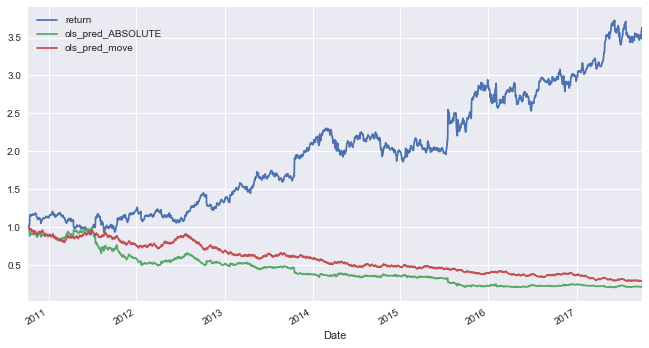

In [59]:
data[['return', 'ols_pred_ABSOLUTE', 'ols_pred_move']].cumsum().apply(np.exp).plot(figsize=(11, 6));

* 'ols_pred_ABSOLUTE' and 'ols_pred_move' from std dev do not reproduce the asset price path at all. This plot reveals the poor quality of prediction.  **FINDING:** correct negatives plus false negatives make for a bad prediction. OLS seems to produce a lot of negative predicitons which do not realise. 


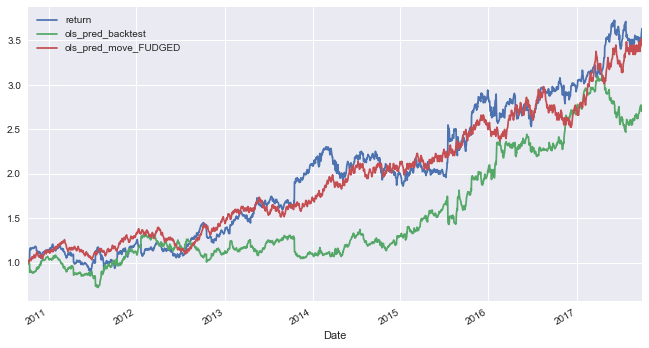

In [60]:
data[['return', 'ols_pred_backtest', 'ols_pred_move_FUDGED']].cumsum().apply(np.exp).plot(figsize=(11, 6));

**INTERIM QUESTIONS** 

* Why 'pred_return' does not match the asset path ('return').  ANSWER: because our prediction is not a prediction but Daily Rebalanced P\&L, where correctly predicted Negative move results in Positive P\&L increment.

* We have done **worse** than buy and hold: simply investing \$100 and holding the position.

<br>

FUDGED inverted sign applied to OLS prediction worked better at reproducing the asset price path. Whoa!

ANSWER: that's likely because of cancelled false negatives, ie, OLS produces a lot of negative predicitons which do not realise.

Remember OLS is an **invalid** regression model for binary dependent variable {0, 1}. **DO NOT** run OLS in your ML assignments and projects.

-----

## Logistic Classifier (Support Vectors in parallel)

In [35]:
from sklearn import linear_model 

from sklearn.svm import SVC  #you can import ANY OTHER CLASSIFIER and proceed in the same way

In [36]:
lm = linear_model.LogisticRegression(C = 1e5) 

svcm = SVC(C= 1e5, probability=True) 

As your vary the main penalty hyparameter C -- what happens to your coefficients for features? 

* **Logistic Classifier**

C= 1e5 is nearly no L2 Penalty because parater set in inverse.

Try strong penalisation C=1 or 0.5 (or 0.01 for mild penalty. 

What about L1 Penalty? (Answer: default setting is L2 penalty and you need to invoke another hyperparameter)

* **SVM Classifier**

C= 1e5 NOT inverse for Support Vector Machines. This is Hard Margins.

Try Soft Margins which supposed to work better on time series.

Try smaller number of features -- SVM might work better


------

### MLE Methodology for Logistic Classification


Let's find an analytical solution to the maximum likelihood estimation problem for a mix of independent identically distributed Bernoulli draws in the regression (prediction) setting.

Each {0,1} outcome has a set of its own explanatory variables $\boldsymbol{X_i}$.

\begin{eqnarray*}
	y_i | \boldsymbol{X_i} \,  &\sim& \, \text{Bernoulli}(p_i)\\ \\ 
	\mathbb{E} \left[ y_i | \boldsymbol{X_i} \right]  \, &=& \, p_i\\ \\
	\text{Pr} \left( y_i = 1,0 \right) \, &=& \,
	\begin{cases}
		\, p_i \\
		\, 1 - p_i
	\end{cases} \\ \\
	f(y_i;p_i) \, &=& \, p_i^{y_i} (1-p_i)^{1-y_i}
\end{eqnarray*}

Each outcome is determined by the probability of default $p_i$, which is unobserved (latent) in the regression model.

#### Part 1
The Bernoulli density above translates to the log-likelihood (contribution from one observation i).

$$ \log{L_i}=  \log f(y_i; p_i) = y_i \log p_i + (1-y_i) \log (1-p_i) $$


The joint log-likelihood for multiple events observed together and treated as independent, is given by the Product Rule of probabilties:
\begin{eqnarray*}
	\log f(y_1, y_2, \ldots, y_N)  &=& \log \prod_{i=1}^{N_{obs}} f(y_i; p_i) \\
	&=& \sum_{i=1}^{N_{obs}} \log f(y_i; p_i)
\end{eqnarray*}


\begin{equation}\label{eqn:JointLhood}
	\log L = \sum_{i=1}^{N_{obs}} \left[ y_i \log p_i + (1-y_i) \log (1-p_i) \right]
\end{equation}

$y_i$ is known from dataset. 

$p_i$ requires inverse of the link $p_i = g^{-1} (\boldsymbol{X_i \beta'})$


#### Part 2
We can express Bernoulli density for a random variable $y = \{1,0\}$ in a more canonical form -- as a member of the Exponential family of distributions.

$$ f(y;p)=p^y(1-p)^{1-y}=\exp\left[y\log\left(\frac{p}{1-p}\right)+\log(1-p)\right] $$

Choice of a link function is \underline{the same for any categorical $\boldsymbol Y$}

$$ g(p) = \log\left(\frac{p}{1-p}\right) $$


This is a logit function (different from logistic function!), which can be read as the ``log of odds''. The inverse of logit function is logistic function, which we are interested in.

$$ p =  \frac{1}{1+e^{-g}} $$

### Link Function -- under the hood of Logistic Classifier

To adapt the linear regression to non-linear output variable $y_i =0,1$ or Binomial $y_i =0, 1,2, 3, 4, \ldots$ or in general case to probability we introduce a non-linear link funciton $y = g(p)$

$$ \text{Dependent Varialbe} \,=\, \text{Link Function} \, ( \, \text{Probability} \,) $$

\begin{eqnarray}
    \mathbf{Y} &=& \boldsymbol{X \beta' +\epsilon} \\
	PD \equiv  \mathbb{E}[\mathbf{Y|X}] &=& \boldsymbol{X \beta'}\\
	g(p) &=& \boldsymbol{X \beta'} \qquad \text{and}\\
	p &=& g(\boldsymbol{X \beta'})^{-1}
\end{eqnarray}

$$ \text{Probability} \,=\, \textbf{Inverse Link Function} \, (\, \text{Dependent Variable} \,) $$

* This covers default/no default $y_i=\{1,0\}$ and ordinal ratings $y_i=1, 2, 3, 4, 5$. In fact, response variable $\boldsymbol{Y}$ can have any distribution from Exponential family (quasi MLE).

* Linear part $\boldsymbol{\beta X}$ is linked to a non-linear, latent variable (probability).
$$  p=g(\boldsymbol{X \beta'})^{-1} $$

A link function is the clever bit that allows to convert a categorical event indicator $y_i=\{1,0\}$ to the probability $p_i$
$$ p_i = g^{-1} (\boldsymbol{X_i \beta'}) $$

$$
	\begin{pmatrix}
		y_{1} \\
		\vdots \\
		y_{n} \\
	\end{pmatrix} \Rightarrow 
	\begin{pmatrix}
		g(\boldsymbol{X_1 \beta'})^{-1} \\
		\vdots \\
		g(\boldsymbol{X_n \beta'})^{-1} \\
	\end{pmatrix} \Rightarrow 
		\begin{pmatrix}
		\text{Prob}_{1} \\
		\vdots \\
		\text{Prob}_{n} \\
	\end{pmatrix}\\
$$

Let's make a step forward and say that the inverse of our link will be  **the logistic sigmoid** function, 

$$ p =  \frac{1}{1+e^{- \boldsymbol{X \beta'}}}  = \frac{e^{\boldsymbol{X \beta'}}}{1+e^{\boldsymbol{X \beta'}}} $$

<p float="middle">
    <img src="image/logistic_sigmoid.png" />
</p>

In [37]:
# use data_adv copy of the dataset

lm.fit(data_adv[cols], data_adv['return_sign'])

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
svcm.fit(data_adv[cols], data_adv['return_sign'])

SVC(C=100000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [29]:
def logistic_sigmoid(xb):
    return (1 / (1 + np.exp(-xb)))

In [119]:
#Procedure RELIES X_Features, Y_Response variables to be existing
def logistic_plot(X_min, X_max, FeatureName, FeatureBetaIdx):  
    
    plt.clf() #clears the figure drawing space, nothing to do with classifier!
    fig, ax = plt.subplots(figsize=(18,10))  #fig = plt.figure(figsize=(18,10))
        
    # 1. Plot two clusters of observations at Y={-1,1} on a scatter
    ax.scatter(data_adv[FeatureName], data_adv['logit_pred'], c=(data_adv['logit_pred']), zorder=20) #X_Features[FeatureName].ravel()
    
    # 2. Plot CALIBRATED sigmoid function -- with the correctly picked coeffient from Logistic Regression
    X_Sim = np.linspace(X_min, X_max, 100) #fill in values for the range of Axe X
    Y_Loss = logistic_sigmoid(X_Sim * lm.coef_[0,FeatureBetaIdx] + lm.intercept_) 
    # Y_Loss = logistic_sigmoid(X_Sim * logit.coef_[0,FeatureBetaIdx] + logit.intercept_).ravel() 
    ax.plot(X_Sim, Y_Loss, color='red', linewidth=3) # plot sigmoid in Red
      
    plt.ylabel('Beta coeff value for sigmoid: -6.138', fontsize=22) # also ax.set_ylabel('Default Indicator')
    plt.xlabel('wrt Feature: ' + FeatureName, fontsize=22)
    plt.xticks(np.linspace(X_min, X_max, num=10), fontsize=14)
    plt.yticks([-1, 1], fontsize=14)
    plt.ylim(-1.1, 1.1)
    plt.xlim(X_min, X_max) #Axe X range
    plt.legend(('Logistic Regression',),
           loc="lower right", fontsize=14)
    #plt.show()
    return ax

<Figure size 432x288 with 0 Axes>

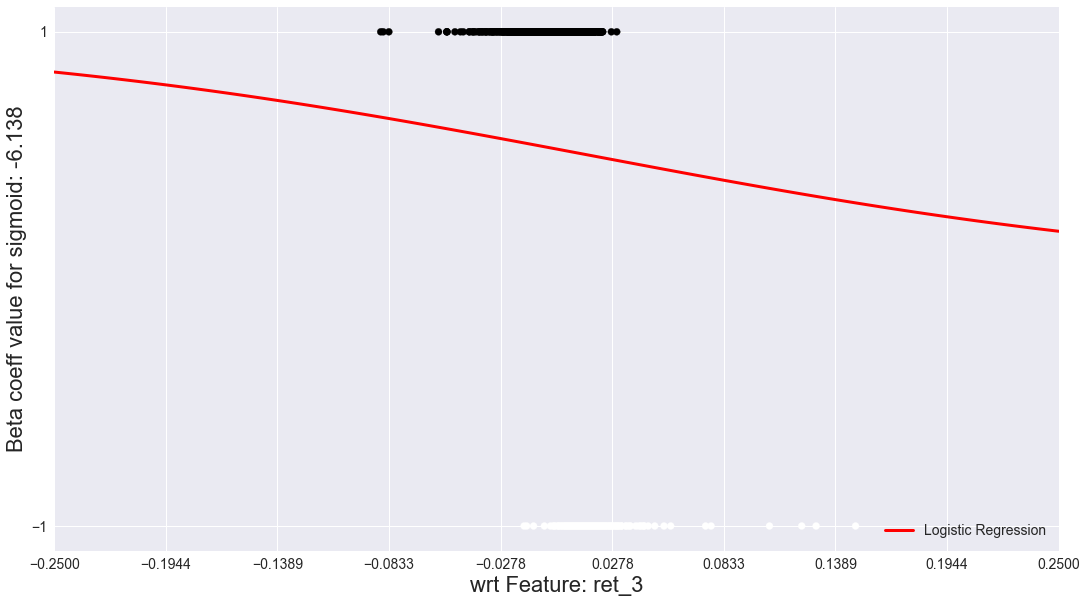

In [123]:
# Error message below will remain due to difference in data types passed into the plotting routine.
# TypeError: 'float' object cannot be interpreted as an integer

logistic_plot(-0.25, 0.25, 'ret_3', 2)

# 'ret_1' has lm.coef_[0,0]

# 'ret_3' has lm.coef_[0,2], the coefficient for our GOOG is -6.13818103, the largest

Above plot implements the inverse of our link will be  **the logistic sigmoid** function, 

$$ p =  \frac{1}{1+e^{- \boldsymbol{X \beta'}}} $$

------

In [122]:
data_adv['logit_pred'] = lm.predict(data_adv[cols])
data_adv['logit_pred_backtest'] = data_adv['return'] * data_adv['logit_pred']

data_adv['svm_pred'] = svcm.predict(data_adv[cols])
data_adv['svm_pred_backtest'] = data_adv['return'] * data_adv['svm_pred'] 

In [62]:
data_adv.head(20)

return     ret_1     ret_2     ret_3     ret_4     ret_5  \
Date                                                                     
2010-10-08  0.011860 -0.008148 -0.007225  0.029947 -0.006245 -0.000305   
2010-10-11  0.004631  0.011860 -0.008148 -0.007225  0.029947 -0.006245   
2010-10-12  0.004720  0.004631  0.011860 -0.008148 -0.007225  0.029947   
2010-10-13  0.003553  0.004720  0.004631  0.011860 -0.008148 -0.007225   
2010-10-14 -0.004370  0.003553  0.004720  0.004631  0.011860 -0.008148   
2010-10-15  0.106028 -0.004370  0.003553  0.004720  0.004631  0.011860   
2010-10-18  0.026677  0.106028 -0.004370  0.003553  0.004720  0.004631   
2010-10-19 -0.016119  0.026677  0.106028 -0.004370  0.003553  0.004720   
2010-10-20  0.000231 -0.016119  0.026677  0.106028 -0.004370  0.003553   
2010-10-21  0.006582  0.000231 -0.016119  0.026677  0.106028 -0.004370   
2010-10-22  0.000885  0.006582  0.000231 -0.016119  0.026677  0.106028   
2010-10-25  0.006468  0.000885  0.006582  0.000231 -0.016119  0.026677   
2010-10-26  0.003381  0.006468  0.000885  0.006582  0.000231 -0.016119   
2010-10-27 -0.003446  0.003381  0.006468  0.000885  0.006582  0.000231   
2010-10-28  0.003446 -0.003446  0.003381  0.006468  0.000885  0.006582   
2010-10-29 -0.007950  0.003446 -0.003446  0.003381  0.006468  0.000885   
2010-11-01  0.002124 -0.007950  0.003446 -0.003446  0.003381  0.006468   
2010-11-02  0.000979  0.002124 -0.007950  0.003446 -0.003446  0.003381   
2010-11-03  0.007408  0.000979  0.002124 -0.007950  0.003446 -0.003446   
2010-11-04  0.006582  0.007408  0.000979  0.002124 -0.007950  0.003446   

            return_sign  logit_pred  logit_pred_return  svm_pred  \
Date                                                               
2010-10-08          1.0        -1.0          -0.011860       1.0   
2010-10-11          1.0         1.0           0.004631       1.0   
2010-10-12          1.0         1.0           0.004720       1.0   
2010-10-13          1.0         1.0           0.003553       1.0   
2010-10-14         -1.0         1.0           0.004370       1.0   
2010-10-15          1.0         1.0           0.106028       1.0   
2010-10-18          1.0         1.0           0.026677      -1.0   
2010-10-19         -1.0         1.0           0.016119       1.0   
2010-10-20          1.0        -1.0          -0.000231      -1.0   
2010-10-21          1.0        -1.0          -0.006582      -1.0   
2010-10-22          1.0        -1.0          -0.000885       1.0   
2010-10-25          1.0         1.0           0.006468       1.0   
2010-10-26          1.0         1.0           0.003381       1.0   
2010-10-27         -1.0         1.0           0.003446       1.0   
2010-10-28          1.0         1.0           0.003446       1.0   
2010-10-29         -1.0         1.0           0.007950       1.0   
2010-11-01          1.0         1.0           0.002124       1.0   
2010-11-02          1.0         1.0           0.000979       1.0   
2010-11-03          1.0         1.0           0.007408       1.0   
2010-11-04          1.0         1.0           0.006582       1.0   

            svm_pred_return  
Date                         
2010-10-08         0.011860  
2010-10-11         0.004631  
2010-10-12         0.004720  
2010-10-13         0.003553  
2010-10-14         0.004370  
2010-10-15         0.106028  
2010-10-18        -0.026677  
2010-10-19         0.016119  
2010-10-20        -0.000231  
2010-10-21        -0.006582  
2010-10-22         0.000885  
2010-10-25         0.006468  
2010-10-26         0.003381  
2010-10-27         0.003446  
2010-10-28         0.003446  
2010-10-29         0.007950  
2010-11-01         0.002124  
2010-11-02         0.000979  
2010-11-03         0.007408  
2010-11-04         0.006582

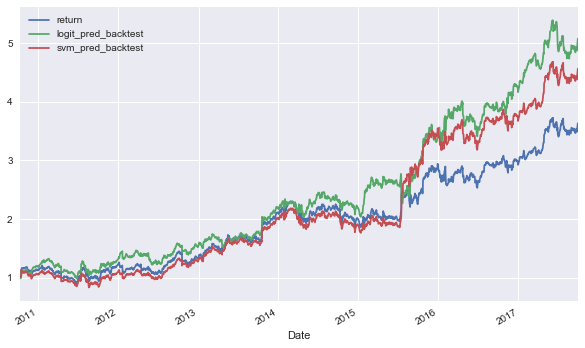

In [65]:
data_adv[['return', 'logit_pred_backtest', 'svm_pred_backtest']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
# Instead of 0.7 we should use simulated Normal Random Variable
#or we end up with just gives exponentially rising plots, no down moves predicted

#data_adv['logit_pred_move'] = 0.7 * stdev * (data_adv['logit_pred'])
#data_adv['svm_pred_move'] = 0.7 * stdev * (data_adv['svm_pred'])

### Further Steps [Assignment]


* Do not rush to a quick conclusion as to which is better SVM/Decision Tree/Logistic Classifer. This is dependent on data history, frequency, historical regime (eg high volatility) and the model itself. SVM estimation with more than 2-3 features becomes very slow. 


* Consider the accuracy and pattern of prediction _within each class_. This is mandatory.


* Investigate the Recall for negative moves, ie, False Negatives problem.


* Since this is binomial prediction $\{0, 1\}$, you can plot **area under the ROC curve** and **confusion matrix** to investigate predictions within each class.


* Think of advantages and disadvantages of moving onto multinomial classification $\{-1,0, 1\}$. For example what would you do if most of observations (daily return) will fall into category of 'no move'.

-----

**END OF DEMONSTRATION**


### More Features

Below is an initial set of features, which econometricans typically utilise, and a good starting-level textbook is _Forecasting Methods and Applications_ by Hyndman, Makridakis, and Wheelwright. They dilligently consider lags, each relevant test such as F-statistic, ARIMA and how to implement seasonality.  However that is typical econometrics aimed at quarterly, cyclically-dependent indicators such as GDP.

It is possible to get professional and utilise a Python wrapper for something like [TA-Lib](https://github.com/mrjbq7/ta-lib). However, we would like to be able to compupte technical analysis indicators from the first princiles, whenever possible.

In [ ]:
def createFeatures(df):
    '''
    Below code features to an existing data frame
    '''
#    df = df.rename(columns={df.columns[0]: 'price'})
#    df['return'] = df.pct_change()
#    df['log_return'] = np.log(df['price']/df['price'].shift(periods=1))
#    df['sign'] = df['log_return'].apply(lambda x: 0 if x<0 else 1)
    df['return_1d']= df['return'].shift(periods=1)
    df['return_2d']= df['return'].shift(periods=2)
    df['return_5d']= df['return'].shift(periods=5)
    df['momentum_1d']=df['price']-df['price'].shift(periods=1)
    df['momentum_2d']=df['price']-df['price'].shift(periods=2)
    df['momentum_5d']=df['price']-df['price'].shift(periods=5)
    df['MA_5d']=df['price'].rolling(5).mean()
    df['MA_10d']=df['price'].rolling(10).mean()
    df['MA_20d']=df['price'].rolling(20).mean()
    df['MA_50d']=df['price'].rolling(20).mean()
    df['EMA_5d']=df['price'].ewm(5, adjust=False).mean()
    df['EMA_10d']=df['price'].ewm(10, adjust=False).mean()
    df['EMA_20d']=df['price'].ewm(20, adjust=False).mean()
    df['EMA_50d']=df['price'].ewm(50, adjust=False).mean()
    return df